In [31]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iter=100, tol=1e-3):
        self.n_components = n_components #number of classes K
        self.max_iter = max_iter #max number of iterations to run
        self.tol = tol #tolerance value under which to stop iterations
        
        self.weights = None #there are our pi_1, . . . , pi_K
        self.means = None #these are our vectors mu_1, . . . ,mu_K
        self.covariances = None #these are our covariance matrices Sigma_1,  . . . , Sigma_K

    def initialize_parameters(self, X):
        """This function initialize the paramters of the GMM"""
        n_samples, _ = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]

    def expectation_step(self, X):
        """complete this function so that it returns the responsibilities"""
        #calculate the vector of 'likelihoods' for every data point, likelihoods will have dimension (n_samples, n_components)
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        
        #multiply likelihoods by weights
        weighted_likelihoods = likelihoods * self.weights
        
        #get responsibilities
        responsibilities = weighted_likelihoods / np.sum(weighted_likelihoods, axis = 1, keepdims = True)
        return responsibilities

    def maximization_step(self, X, responsibilities):
        """complete this function that updates means, covariances and weights"""
        
        # get the number N_m, m = 1, . . ., K
        total_responsibilities = np.sum(responsibilities, axis = 0)

        self.means = np.dot(responsibilities.T, X) / total_responsibilities[:, np.newaxis]

        self.covariances = []
        for m in range(self.n_components):
            diff = X - self.means[m]
            cov_m = np.dot(responsibilities[:,m]*diff.T, diff) / total_responsibilities[m]
            self.covariances.append(cov_m)
            
        #update the weights by dividing total_responsibilities by the number of samples    
        self.weights = total_responsibilities / len(X)
            
    def compute_logLikelihood(self, X):
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        weighted_likelihoods = self.weights * likelihoods
        log_likelihood = np.sum(np.log(np.sum(weighted_likelihoods, axis=1)))
        return log_likelihood

    def fit(self, X):
        self.initialize_parameters(X)
        
        
        for i in range(self.max_iter):
            old_log_likelihood = self.compute_logLikelihood(X)

            responsibilities = self.expectation_step(X) #Expectation Step
            self.maximization_step(X, responsibilities) #Maximization Step
            
            new_log_likelihood = self.compute_logLikelihood(X)
            
            # Check for convergence of the log_likelihood
            if np.abs(old_log_likelihood - new_log_likelihood) < self.tol:
                break

    def predict(self, X):
        likelihoods = np.array([multivariate_normal.pdf(X, mean, cov) for mean, cov in zip(self.means, self.covariances)]).T
        return np.argmax(likelihoods, axis=1)

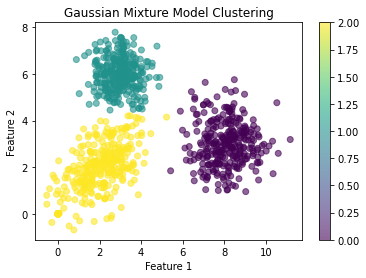

In [32]:
### DO NOT CHANGE THIS PART

np.random.seed(0)
num_samples = 1000
num_features = 2
num_components = 3
means = np.array([[2, 2], [8, 3], [3, 6]])
covariances = np.array([[[1, 0.5], [0.5, 1]], [[1, 0], [0, 1]], [[0.5, 0], [0, 0.5]]])
weights = np.array([0.4, 0.3, 0.3])

X = np.zeros((num_samples, num_features))
for i in range(num_components):
    num_samples_i = int(weights[i] * num_samples)
    X[i * num_samples_i: (i + 1) * num_samples_i] = np.random.multivariate_normal(means[i], covariances[i], num_samples_i)

# Fit Gaussian Mixture Model
gmm = GaussianMixtureModel(n_components=num_components)
gmm.fit(X)

# Predict cluster probabilities 
predicted_lab = gmm.predict(X)

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=predicted_lab, cmap='viridis', alpha=0.6)


plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian Mixture Model Clustering')
plt.colorbar()
plt.show()